In [2]:
push!(LOAD_PATH, "./GannSwing/src")
using Statistics
using GannSwing
using Plots
gr()


Plots.GRBackend()

In [3]:
using TimeSeries
ta_all=readtimearray("./data/USDJPY_20160101_20181222.csv",format="dd.mm.yyyy HH:MM:SS.sss")


1565280×5 TimeArray{Float64,2,DateTime,Array{Float64,2}} 2016-01-01T00:00:00 to 2018-12-22T23:59:00
│                     │ Open    │ High    │ Low     │ Close   │ Volume │
├─────────────────────┼─────────┼─────────┼─────────┼─────────┼────────┤
│ 2016-01-01T00:00:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:01:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:02:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:03:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:04:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:05:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:06:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:07:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:08:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:09:00 │ 120.23  │ 120.23  │ 120.23  │ 120.23  │ 0.0    │
│ 2016-01-01T00:10:00 │ 

In [4]:
function _lag(a::Array{T,1},n::Int=1) where T<: Number
    if length(a) > n
        a[1+n:end].-a[1:end-n]
    else
        error(:OutOfIndex)
    end
end
    
_lag([2,6,2,6,3,4])    
_lag([2.0,6.0,2.5,6.8,3.3,4.3])

5-element Array{Float64,1}:
  4.0
 -3.5
  4.3
 -3.5
  1.0

In [44]:
i=1
idx=[]
ta_all=ta_all[end-30000:end]
sz=length(ta_all)
while(i<=sz)
    y,m,d = (yearmonthday(timestamp(ta_all[i])[1]))
    new_i = searchsortedfirst(timestamp(ta_all),DateTime(y,m,d)+Day(1))
    if(i == (new_i - 1)) break end
    push!(idx,[i,new_i-1])
    i=new_i
end
print("１日の開始バーと終了バーのインデックスを集める")
idx

１日の開始バーと終了バーのインデックスを集める

21-element Array{Any,1}:
 [1, 1201]     
 [1202, 2641]  
 [2642, 4081]  
 [4082, 5521]  
 [5522, 6961]  
 [6962, 8401]  
 [8402, 9841]  
 [9842, 11281] 
 [11282, 12721]
 [12722, 14161]
 [14162, 15601]
 [15602, 17041]
 [17042, 18481]
 [18482, 19921]
 [19922, 21361]
 [21362, 22801]
 [22802, 24241]
 [24242, 25681]
 [25682, 27121]
 [27122, 28561]
 [28562, 30001]

左) GannSwing のスイングポイントの上下動を表したもの
右) 絶対値をとったものでボラティリティを見るのに使う

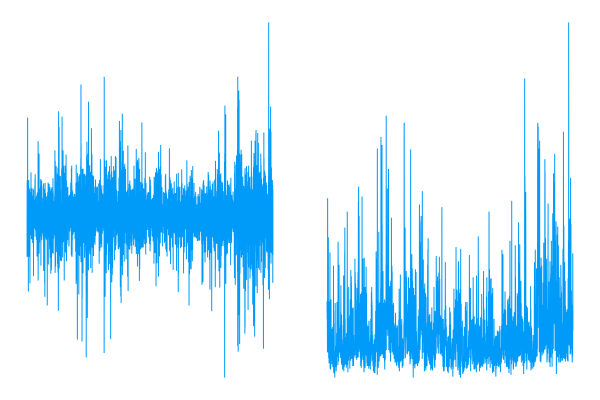

In [37]:
swing = Float64[]
raw=Float64[]
volat=Float64[]
gann_obj=GannSwingObj(2)
for i in eachindex(idx)  
    ta = ta_all[idx[i][1]:idx[i][2]]
    for j in eachindex(ta)
        (_,_,_y) = calculate(gann_obj,ta,j)
        append!(swing,_y)
    end           
    if(length(swing) > 100)
        temp = _lag(swing)
        append!(raw,temp)
        append!(volat,abs.(temp))
        swing = Float64[]
    end 
end
print("左) GannSwing のスイングポイントの上下動を表したもの\n")
print("右) 絶対値をとったものでボラティリティを見るのに使う")
plot([raw,volat],layout=2,leg=false,ticks=nothing,border=:none)


ヒストグラムで見ると結構なロングテールになる

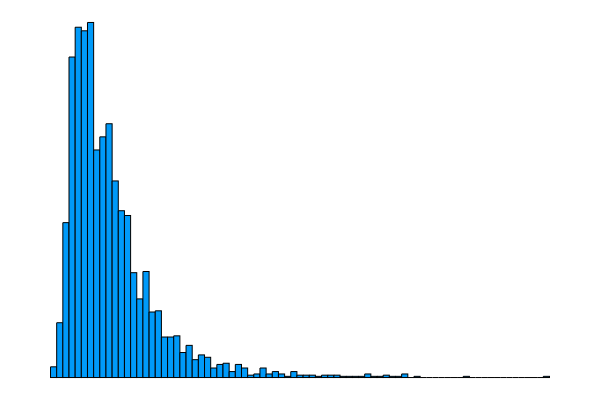

In [41]:
print("ヒストグラムで見ると結構なロングテールになる")
histogram([volat],leg=false,ticks=nothing,border=:none)

98%で尻尾を切ってみる

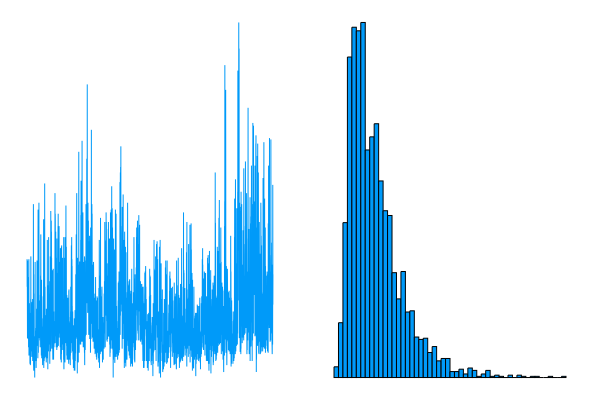

In [42]:

volat=Float64[]
log_volat=Float64[]
swing = Float64[]
gann_obj=GannSwingObj(2)
for i in eachindex(idx)    
    ta = ta_all[idx[i][1]:idx[i][2]]
    for j in eachindex(ta)
        (_,_,_y) = calculate(gann_obj,ta,j)
        append!(swing,_y)
    end           
    if(length(swing) > 100)
        temp = abs.(_lag(swing)).*10000
        lim = quantile(temp, 0.98)
        filter!(x -> (x <= lim),temp)
        append!(volat,temp)
        append!(log_volat,log.(temp))
        swing = Float64[]
    end 
end
print("98%で尻尾を切ってみる\nすこし整ってきた。")
plot([volat,volat],layout=2,t=[:line :histogram], leg=false,ticks=nothing,border=:none )

さらに対数を使ってみる。

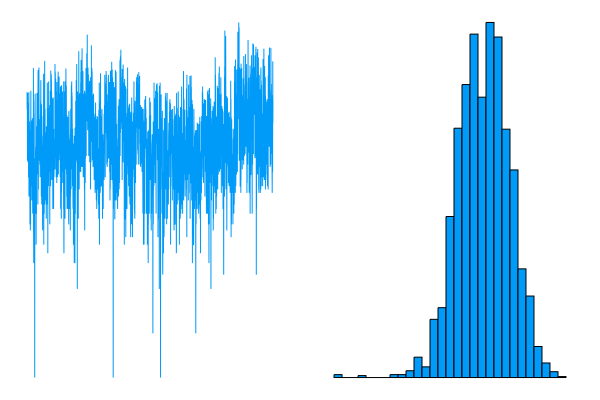

In [43]:
print("さらに対数を使ってみる。")
plot([log_volat,log_volat],layout=2,t=[:line :histogram], leg=false,ticks=nothing,border=:none)